<a href="https://colab.research.google.com/github/Bassam-Alswehry/crowd-management-ai-system/blob/main/CrowdCounting__V1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install kagglehub h5py tqdm
# !pip -q install opencv-python-headless==4.9.0.80

In [ ]:
# مسارات الداتا من KaggleHub
!pip -q install kagglehub h5py tqdm

import os, glob
import kagglehub

DATA_ROOT = kagglehub.dataset_download("tthien/shanghaitech")
BASE = os.path.join(DATA_ROOT, "ShanghaiTech")

# نستخدم Part_B (أنسب لكثافات متوسطة/قليلة)
B_TRAIN_IMG = os.path.join(BASE, "part_B/train_data/images")
B_TRAIN_GT  = os.path.join(BASE, "part_B/train_data/ground-truth-h5")
B_VAL_IMG   = os.path.join(BASE, "part_B/test_data/images")          # نستخدم test كـ val خفيف
B_VAL_GT    = os.path.join(BASE, "part_B/test_data/ground-truth-h5")

print("Train imgs:", len(glob.glob(os.path.join(B_TRAIN_IMG, "*.jpg"))))
print("Val   imgs:", len(glob.glob(os.path.join(B_VAL_IMG,   "*.jpg"))))

Using Colab cache for faster access to the 'shanghaitech' dataset.
Train imgs: 400
Val   imgs: 316


In [ ]:
import torch
import torch.nn as nn
import torchvision

class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        # frontend = VGG16 layers (conv/pool) بدون الـ classifier
        vgg = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_FEATURES)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])  # إلى conv4_3

        # backend = dilated convs
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(128,  64, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
        )
        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CSRNet().to(device)
print("CSRNet created on", device)

CSRNet created on cuda


In [ ]:
!pip uninstall -y numpy opencv-python opencv-python-headless scipy

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: opencv-python-headless 4.12.0.88
Uninstalling opencv-python-headless-4.12.0.88:
  Successfully uninstalled opencv-python-headless-4.12.0.88
Found existing installation: scipy 1.16.1
Uninstalling scipy-1.16.1:
  Successfully uninstalled scipy-1.16.1


In [ ]:
!pip install --no-cache-dir --force-reinstall numpy==1.26.4 scipy==1.11.4 opencv-python-headless==4.9.0.80 h5py==3.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 231.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 236.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 181.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 99.9 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.14.0
    Uninstalling h5py-3.14.0:
      Successfully uninstalled h5py-3.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.

In [ ]:
import numpy as np, cv2, scipy, h5py
print("numpy:", np.__version__)
print("scipy:", scipy.__version__)
print("cv2:", cv2.__version__)
print("h5py:", h5py.__version__)

numpy: 1.26.4
scipy: 1.11.4
cv2: 4.9.0
h5py: 3.11.0


In [ ]:
import cv2, h5py, numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CrowdDataset(Dataset):
    def __init__(self, img_dir, gt_dir=None, transform=None):
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
        self.gt_paths  = sorted(glob.glob(os.path.join(gt_dir,  "*.h5"))) if gt_dir else []
        self.transform = transform

    def __len__(self): return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        img = np.transpose(img, (2,0,1))  # CHW

        if self.gt_paths and idx < len(self.gt_paths):
            with h5py.File(self.gt_paths[idx], 'r') as f:
                den = np.array(f['density']).astype(np.float32)
            den = den[np.newaxis, ...]  # (1,H,W)
        else:
            den = np.zeros((1, img.shape[1], img.shape[2]), dtype=np.float32)

        img = torch.tensor(img, dtype=torch.float32)
        den = torch.tensor(den, dtype=torch.float32)
        return img, den

In [ ]:
import kagglehub, os

DATA_ROOT = kagglehub.dataset_download("tthien/shanghaitech")
BASE = os.path.join(DATA_ROOT, "ShanghaiTech")

# مسارات Part_B
B_TRAIN_IMG = os.path.join(BASE, "part_B/train_data/images")
B_TRAIN_GT  = os.path.join(BASE, "part_B/train_data/ground-truth-h5")
B_TEST_IMG  = os.path.join(BASE, "part_B/test_data/images")
B_TEST_GT   = os.path.join(BASE, "part_B/test_data/ground-truth-h5")

print("Train IMG dir:", B_TRAIN_IMG)
print("Train GT dir :", B_TRAIN_GT)
print("Test IMG dir :", B_TEST_IMG)
print("Test GT dir  :", B_TEST_GT)

Using Colab cache for faster access to the 'shanghaitech' dataset.
Train IMG dir: /kaggle/input/shanghaitech/ShanghaiTech/part_B/train_data/images
Train GT dir : /kaggle/input/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth-h5
Test IMG dir : /kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/images
Test GT dir  : /kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth-h5


In [ ]:
import cv2, h5py, numpy as np, os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from glob import glob

# تعريف Dataset
class CrowdDataset(Dataset):
    def __init__(self, img_dir, gt_dir, transform=None):
        self.img_paths = sorted(glob(os.path.join(img_dir, '*.jpg')))
        self.gt_paths  = sorted(glob(os.path.join(gt_dir,  '*.h5')))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        img = np.transpose(img, (2,0,1)).astype(np.float32)

        with h5py.File(self.gt_paths[idx], 'r') as f:
            density = np.array(f['density'])
        density = density.astype(np.float32)[np.newaxis, ...]

        return torch.tensor(img), torch.tensor(density)

# تجهيز التحويلات (بسيطة حالياً)
train_tf = transforms.Compose([
    transforms.ToTensor()
])

# إنشاء Dataset
train_set = CrowdDataset(B_TRAIN_IMG, B_TRAIN_GT, transform=train_tf)
val_set   = CrowdDataset(B_TEST_IMG,  B_TEST_GT,  transform=train_tf)

# إنشاء DataLoader
train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=1, shuffle=False, num_workers=2)

print("loaders ready:")
print("Train samples:", len(train_set))
print("Val samples:", len(val_set))

loaders ready:
Train samples: 400
Val samples: 316


In [ ]:
import os, cv2, h5py, numpy as np, torch
from glob import glob
from torch.utils.data import Dataset

class CrowdDataset(Dataset):
    def __init__(self, img_dir, gt_dir=None):
        self.img_paths = sorted(glob(os.path.join(img_dir, "*.jpg")))
        self.gt_dir    = gt_dir

    def __len__(self):
        return len(self.img_paths)

    def _img_to_h5(self, img_path):
        if not self.gt_dir: return None
        base = os.path.basename(img_path)          # IMG_12.jpg
        stem = os.path.splitext(base)[0]           # IMG_12
        return os.path.join(self.gt_dir, f"GT_{stem}.h5")  # GT_IMG_12.h5

    def __getitem__(self, idx):
        # image -> Tensor (C,H,W)
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        img = np.transpose(img, (2,0,1)).astype(np.float32)

        # density map
        gt = np.zeros((1, img.shape[1], img.shape[2]), dtype=np.float32)
        h5_path = self._img_to_h5(img_path)
        if h5_path and os.path.exists(h5_path):
            with h5py.File(h5_path, "r") as f:
                d = np.array(f["density"]).astype(np.float32)  # (H,W)
            gt = d[np.newaxis, ...]                            # (1,H,W)

        return torch.from_numpy(img), torch.from_numpy(gt)

In [ ]:
from torch.utils.data import DataLoader, random_split

full_set = CrowdDataset(B_TRAIN_IMG, B_TRAIN_GT)
n_total  = len(full_set)
n_train  = int(0.8 * n_total)
n_val    = n_total - n_train
train_set, val_set = random_split(full_set, [n_train, n_val])

train_loader = DataLoader(train_set, batch_size=1, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_set,   batch_size=1, shuffle=False, num_workers=0)

print("Train:", len(train_set), "| Val:", len(val_set))

TypeError: 'module' object is not callable. Did you mean: 'glob.glob(...)'?

In [ ]:
import torch.nn.functional as F

DOWNSAMPLE = 8  # CSRNet يقلل الحجم 1/8

def resize_gt(gt, preds):
    """
    يعيد تحجيم الـGT عشان يطابق حجم الـpreds
    gt: [B, 1, H, W]
    preds: [B, 1, H/8, W/8]
    """
    _, _, h, w = preds.shape
    return F.interpolate(gt, size=(h, w), mode='bilinear', align_corners=False)

In [ ]:
import torch, time, os
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# نعرف الجهاز
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# تعريف الخسارة والمهيئ
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# عدد epochs
EPOCHS = 100

# مكان حفظ النماذج
SAVE_DIR = "/content/runs_csrnet"
os.makedirs(SAVE_DIR, exist_ok=True)

# اسم الملف النهائي
FINAL_PATH = os.path.join(SAVE_DIR, "csrnet_partB_final_100epochs.pth")

start = time.time()

for ep in range(EPOCHS):
    model.train()
    running = 0.0

    for imgs, gts in tqdm(train_loader, desc=f"Epoch {ep+1}/{EPOCHS}"):
        imgs, gts = imgs.to(device).float(), gts.to(device).float()

        preds = model(imgs)
        gts_resized = resize_gt(gts, preds)   # عشان المقاسات تتطابق
        loss = criterion(preds, gts_resized)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item()

    print(f"Epoch {ep+1}/{EPOCHS} | TrainLoss: {running/len(train_loader):.4f}")

    # كل 10 Epochs نحفظ Checkpoint
    if (ep+1) % 10 == 0:
        tmp_path = os.path.join(SAVE_DIR, f"csrnet_partB_ep{ep+1}.pth")
        torch.save(model.state_dict(), tmp_path)
        print(f"✅ Saved checkpoint: {tmp_path}")

# الحفظ النهائي
torch.save(model.state_dict(), FINAL_PATH)
print(f"\n Training done in {(time.time()-start)/60:.1f} min")
print(f"Final model saved at: {FINAL_PATH}")

Device: cuda


Epoch 1/100:  42%|████▎     | 136/320 [00:07<00:10, 17.23it/s]


KeyboardInterrupt: 

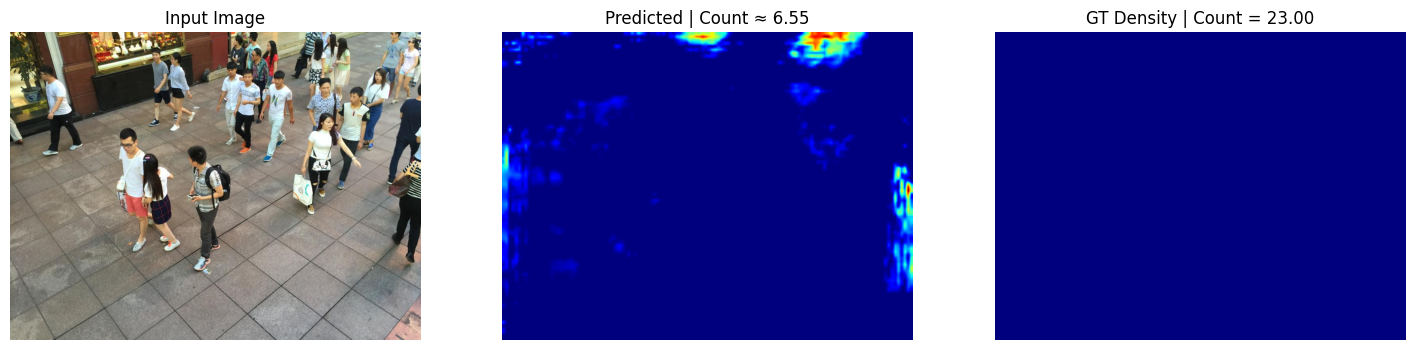

IMG: IMG_1.jpg
Predicted: 6.55 | GT: 23.00


In [ ]:
# === اختبار منضبط: eval + منع القيم السالبة + تطابق الـpreprocess ===
import os, cv2, numpy as np, torch
import torch.nn.functional as F
import h5py, scipy.io as sio
import matplotlib.pyplot as plt

model.eval()  # مهم جداً
device = next(model.parameters()).device

def load_gt_any(img_path):
    """يحاول يجيب ملف GT المطابق للصورة سواء .mat أو .h5"""
    base = os.path.dirname(os.path.dirname(img_path))            # .../test_data
    # مسارات محتملة
    name = os.path.splitext(os.path.basename(img_path))[0]       # IMG_XX
    # .mat
    p_mat = os.path.join(base, "ground-truth", f"GT_{name}.mat")
    # .h5
    p_h5  = os.path.join(base, "ground-truth-h5", f"{name}.h5")
    if os.path.exists(p_mat):
        gt = sio.loadmat(p_mat)["image_info"][0][0][0][0][0]  # نقاط الرؤوس
        # نحول النقاط لخريطة كثافة بسيطة (تفريغ نقاط)، للعرض فقط
        img = cv2.imread(img_path); h,w = img.shape[:2]
        dm = np.zeros((h,w), np.float32)
        for (x,y) in gt:
            xi, yi = int(round(x))-1, int(round(y))-1
            if 0 <= yi < h and 0 <= xi < w: dm[yi, xi] = 1.0
        return dm.astype(np.float32), float(len(gt))
    elif os.path.exists(p_h5):
        with h5py.File(p_h5, "r") as f:
            dm = np.array(f["density"]).squeeze().astype(np.float32)
        return dm, float(dm.sum())
    else:
        return None, None

def predict_count(img_path):
    # قراءة الصورة + نفس التطبيع المستخدم بالتدريب (قسمة 255 فقط)
    bgr = cv2.imread(img_path); assert bgr is not None, f"لم أجد الصورة: {img_path}"
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    h, w = rgb.shape[:2]
    x = torch.tensor(rgb).permute(2,0,1).unsqueeze(0).float().to(device) / 255.0

    with torch.no_grad():
        y = model(x)                    # [1,1,H/8,W/8]
        y = torch.relu(y)               # منع السالب ✅
        y_up = F.interpolate(y, size=(h,w), mode='bilinear', align_corners=False)
        dm_pred = y_up[0,0].cpu().numpy().astype(np.float32)
        cnt_pred = float(dm_pred.sum())
    return rgb, dm_pred, cnt_pred

test_img_path = "/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/images/IMG_1.jpg"  # عدّلها لو لازم
img_rgb, dm_pred, pred_count = predict_count(test_img_path)
gt_dm, gt_count = load_gt_any(test_img_path)

# عرض
plt.figure(figsize=(18,6))
plt.subplot(1,3,1); plt.imshow(img_rgb); plt.title("Input Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(dm_pred, cmap="jet"); plt.title(f"Predicted | Count ≈ {pred_count:.2f}"); plt.axis("off")
if gt_dm is not None:
    plt.subplot(1,3,3); plt.imshow(gt_dm, cmap="jet");
    plt.title(f"GT Density | Count = {gt_count:.2f}"); plt.axis("off")
plt.show()

print(f"IMG: {os.path.basename(test_img_path)}")
if gt_dm is not None:
    print(f"Predicted: {pred_count:.2f} | GT: {gt_count:.2f}")
else:
    print(f"Predicted: {pred_count:.2f} | GT: (لا يوجد ملف GT موافق)")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


Saving image_001.jpeg to image_001.jpeg
Saving image_002.jpeg to image_002.jpeg
Saving image_003.jpeg to image_003.jpeg
Saving image_004.jpeg to image_004.jpeg
Saving image_005.jpeg to image_005.jpeg
Saving image_006.jpeg to image_006.jpeg
Saving image_007.jpeg to image_007.jpeg
Saving image_008.jpeg to image_008.jpeg
Saving image_009.jpeg to image_009.jpeg
Saving image_010.jpeg to image_010.jpeg
✔️ تم حفظ 10 ملف (أو أقل إن وُجدت صيغ غير صور) داخل: /content/data/haram/images

 تم تجهيز النقاط لعدد 20 صورة.
 مجموع النقاط: 164
 CSV للأعداد: /content/data/haram/counts.csv
 نقاط كل صورة داخل: /content/data/haram/points
 صور المعاينة داخل: /content/data/haram/preview


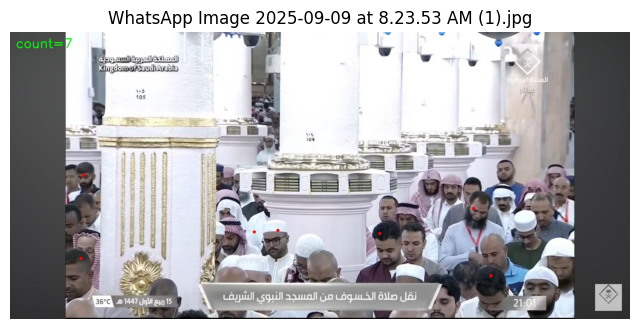

In [ ]:

!pip -q install ultralytics==8.3.0 opencv-python-headless==4.9.0.80 > /dev/null

import os, cv2, csv, glob, math, shutil
import numpy as np
import torch
from ultralytics import YOLO

ROOT      = "/content/data/haram"
IMG_DIR   = f"{ROOT}/images"     # ضع صورك هنا بأسماء image_001.jpg ... إلخ
PTS_DIR   = f"{ROOT}/points"
PREV_DIR  = f"{ROOT}/preview"
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(PTS_DIR, exist_ok=True)
os.makedirs(PREV_DIR, exist_ok=True)

try:
    from google.colab import files
    uploads = files.upload()     # اختر صور JPG/PNG
    if uploads:
        # امسح الموجود لو تحب تبدأ نظيف (علّق السطر التالي لو ما تبي تمسح)
        # for p in glob.glob(f"{IMG_DIR}/*"): os.remove(p)
        names = sorted(list(uploads.keys()))
        for i, name in enumerate(names, 1):
            ext = os.path.splitext(name)[1].lower()
            if ext not in [".jpg", ".jpeg", ".png"]:
                continue
            new_name = f"image_{i:03d}.jpg"  # توحيد الامتداد إلى jpg
            src = name
            dst = os.path.join(IMG_DIR, new_name)
            img = cv2.imdecode(np.frombuffer(uploads[name], np.uint8), cv2.IMREAD_COLOR)
            assert img is not None, f"فشل فتح: {name}"
            cv2.imwrite(dst, img, [cv2.IMWRITE_JPEG_QUALITY, 95])
        print(f"✔️ تم حفظ {len(names)} ملف (أو أقل إن وُجدت صيغ غير صور) داخل: {IMG_DIR}")
except Exception as e:
    pass


device = 0 if torch.cuda.is_available() else "cpu"
model = YOLO("yolov8n.pt")

# إعدادات الكشف
CONF = 0.35   # عتبة الثقة
IOU  = 0.45   # iou
CLS  = [0]    # فئة الشخص


def box_to_head_point(xyxy):
    x1, y1, x2, y2 = xyxy
    # نأخذ نقطة أعلى-وسط الصندوق كتمثيل تقريبي للرأس
    cx = (x1 + x2) / 2.0
    cy = y1 + 0.2 * (y2 - y1)  # أعلى 20% من الصندوق
    return int(round(cx)), int(round(cy))


img_paths = sorted(glob.glob(os.path.join(IMG_DIR, "*.*")))
assert img_paths, f"لا توجد صور داخل: {IMG_DIR}"

counts_csv = os.path.join(ROOT, "counts.csv")
total_pts = 0
written = 0

with open(counts_csv, "w", newline="", encoding="utf-8") as fcnt:
    writer = csv.writer(fcnt)
    writer.writerow(["filename", "count"])  # رأس الجدول

    for ip in img_paths:
        # قراءة الصورة
        img = cv2.imread(ip)
        if img is None:
            print("⚠️ تخطي صورة غير قابلة للقراءة:", ip)
            continue
        H, W = img.shape[:2]

        # كشف الأشخاص
        res = model.predict(ip, conf=CONF, iou=IOU, classes=CLS, device=device, verbose=False)[0]

        # تحويل الصناديق لنقاط رؤوس
        points = []
        if res.boxes is not None and len(res.boxes) > 0:
            for b in res.boxes.xyxy.cpu().numpy():
                px, py = box_to_head_point(b)
                # قص للنطاق الصحيح
                px = max(0, min(W - 1, px))
                py = max(0, min(H - 1, py))
                points.append((px, py))

        # كتابة CSV x,y لهذه الصورة
        base = os.path.splitext(os.path.basename(ip))[0]
        csv_path = os.path.join(PTS_DIR, f"{base}.csv")
        with open(csv_path, "w", newline="", encoding="utf-8") as fc:
            cw = csv.writer(fc)
            cw.writerow(["x", "y"])
            cw.writerows(points)

        # تحديث counts.csv
        writer.writerow([os.path.basename(ip), len(points)])
        total_pts += len(points)
        written += 1

        # رسم المعاينة
        vis = img.copy()
        for (x, y) in points:
            cv2.circle(vis, (x, y), 4, (0, 0, 255), -1)  # نقطة حمراء
        cv2.putText(vis, f"count={len(points)}", (15, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0,255,0), 2)
        cv2.imwrite(os.path.join(PREV_DIR, f"{base}.jpg"), vis)

print(f"\n تم تجهيز النقاط لعدد {written} صورة.")
print(f" مجموع النقاط: {total_pts}")
print(f" CSV للأعداد: {counts_csv}")
print(f" نقاط كل صورة داخل: {PTS_DIR}")
print(f" صور المعاينة داخل: {PREV_DIR}")

# معاينة سريعة لأول صورة
try:
    import matplotlib.pyplot as plt
    first_prev = sorted(glob.glob(os.path.join(PREV_DIR, "*.jpg")))[0]
    plt.figure(figsize=(8,6)); plt.imshow(cv2.cvtColor(cv2.imread(first_prev), cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(os.path.basename(first_prev)); plt.show()
except:
    pass

✅ Found pairs: 20

🖼️ سنعرض 10 صورة (من الأزواج المطابقة).


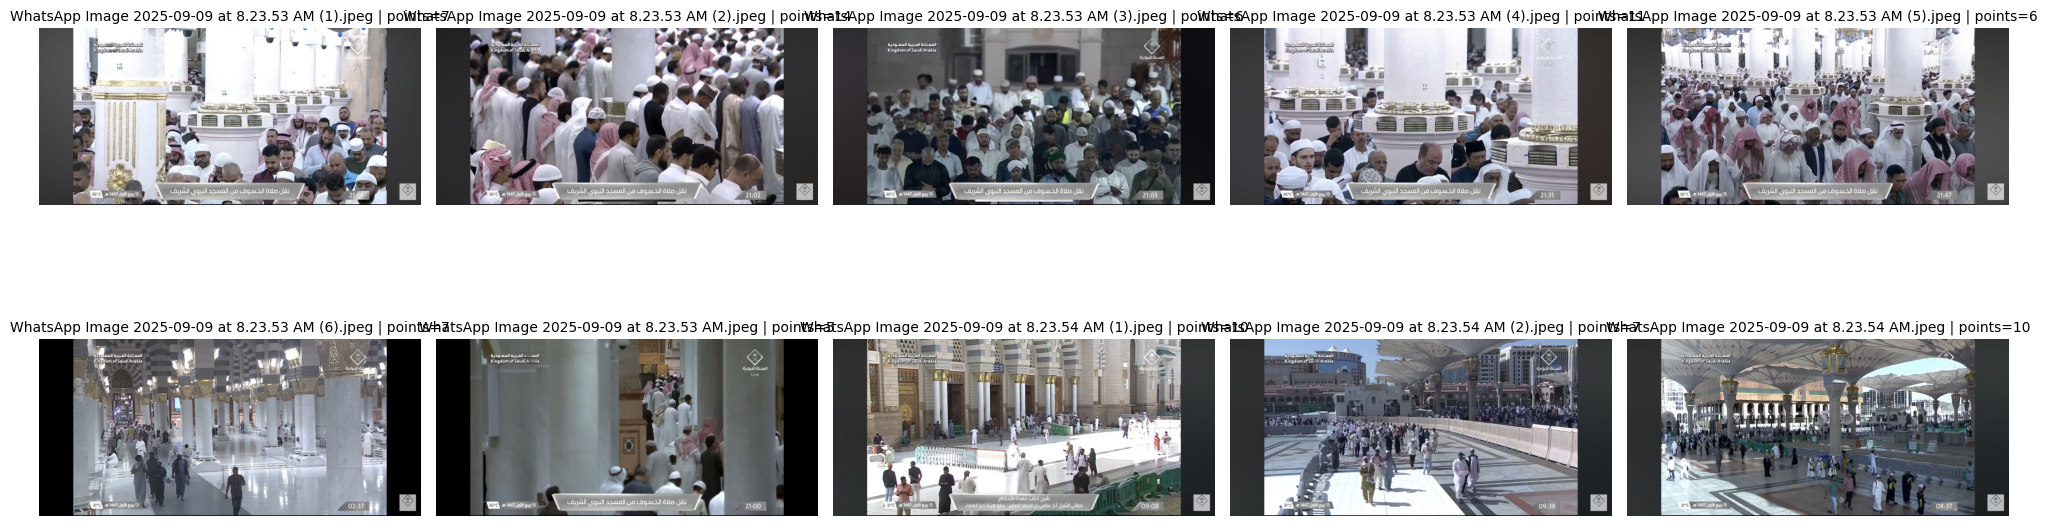


👀 أمثلة من الأزواج (أول 3):
 - WhatsApp Image 2025-09-09 at 8.23.53 AM (1).jpeg <-> WhatsApp Image 2025-09-09 at 8.23.53 AM (1).csv
 - WhatsApp Image 2025-09-09 at 8.23.53 AM (2).jpeg <-> WhatsApp Image 2025-09-09 at 8.23.53 AM (2).csv
 - WhatsApp Image 2025-09-09 at 8.23.53 AM (3).jpeg <-> WhatsApp Image 2025-09-09 at 8.23.53 AM (3).csv


In [ ]:

import os, glob, csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_DIR = "/content/data/haram/images"   # عدل المسار إذا لزم
PTS_DIR = "/content/data/haram/points"   # عدل المسار إذا لزم

# ===== دالة لحساب عدد النقاط داخل CSV =====
def count_points(csv_path):
    cnt = 0
    with open(csv_path, "r", encoding="utf-8") as f:
        rdr = csv.reader(f)
        for row in rdr:
            # نقبل أي صف يحتوي عمودين رقميين (x,y)
            if len(row) >= 2:
                try:
                    float(row[0]); float(row[1])
                    cnt += 1
                except:
                    # تخطَّ الصف لو ما كان رقمي (مثلاً هيدر)
                    pass
    return cnt


img_paths = []
for pat in ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"):
    img_paths.extend(glob.glob(os.path.join(IMG_DIR, pat)))

pairs = []
missing_csv = []
for ip in sorted(img_paths):
    stem = os.path.splitext(os.path.basename(ip))[0]  # اسم الملف دون الامتداد
    cp = os.path.join(PTS_DIR, stem + ".csv")
    if os.path.exists(cp):
        pairs.append((ip, cp))
    else:
        missing_csv.append(ip)

print(f"✅ Found pairs: {len(pairs)}")
if missing_csv:
    print(f"⚠️ Images without CSV: {len(missing_csv)} (سيتم تجاهلها)")
    # لو تبي تشوف أول كم واحدة مفقودة:
    # for p in missing_csv[:5]: print(" -", os.path.basename(p))


top = pairs[:10]
n = len(top)
print(f"\n🖼️ سنعرض {n} صورة (من الأزواج المطابقة).")

if n == 0:
    raise RuntimeError("لم يتم إيجاد أي زوج (صورة + CSV). تأكد من الأسماء.")

cols = 5
rows = int(np.ceil(n / cols))
plt.figure(figsize=(4*cols, 3.8*rows))

for i, (img_path, csv_path) in enumerate(top, 1):
    img = cv2.imread(img_path)
    if img is None:
        title = f"{os.path.basename(img_path)} | (لم تُقرأ الصورة)"
        rgb = np.zeros((200, 300, 3), dtype=np.uint8)
        cnt = 0
    else:
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cnt = count_points(csv_path)
        title = f"{os.path.basename(img_path)} | points={cnt}"

    ax = plt.subplot(rows, cols, i)
    ax.imshow(rgb)
    ax.set_title(title, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


print("\n👀 أمثلة من الأزواج (أول 3):")
for ip, cp in top[:3]:
    print(" -", os.path.basename(ip), "<->", os.path.basename(cp))

In [ ]:

IMG_DIR    = "/content/data/haram/images"
POINTS_DIR = "/content/data/haram/points"   # ملف لكل صورة يحوي x,y بدون عناوين

import os, glob, csv, cv2, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

DOWNSAMPLE = 8

def make_density_map(H, W, pts, sigma=4.0, downsample=8):
    h, w = H//downsample, W//downsample
    dm = np.zeros((h, w), dtype=np.float32)
    if len(pts):
        for (x, y) in pts:
            xi = min(w-1, max(0, int(round(x/downsample))))
            yi = min(h-1, max(0, int(round(y/downsample))))
            dm[yi, xi] += 1.0
    dm = cv2.GaussianBlur(dm, (0,0), sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_REFLECT101)
    return torch.from_numpy(dm)[None, ...]  # [1,h,w]

def read_points_csv(csv_path):
    pts = []
    with open(csv_path, "r", encoding="utf-8") as f:
        r = csv.reader(f)
        for row in r:
            if len(row) >= 2:
                try:
                    x = float(row[0]); y = float(row[1])
                    pts.append((x, y))
                except:
                    pass
    return pts

class HaramPointsDataset(Dataset):
    def __init__(self, img_dir, points_dir, downsample=8, transform=None):
        self.img_dir = img_dir
        self.points_dir = points_dir
        self.downsample = downsample
        self.transform = transform

        imgs = sorted(glob.glob(os.path.join(img_dir, "*.jpg")) +
                      glob.glob(os.path.join(img_dir, "*.jpeg")) +
                      glob.glob(os.path.join(img_dir, "*.png")))
        pairs = []
        for ip in imgs:
            base = os.path.splitext(os.path.basename(ip))[0]
            cand = [os.path.join(points_dir, base + ".csv"),
                    os.path.join(points_dir, base + ".txt")]
            cp = next((p for p in cand if os.path.exists(p)), None)
            if cp: pairs.append((ip, cp))
        self.items = pairs

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, csv_path = self.items[idx]
        img = cv2.imread(img_path)
        if img is None: raise RuntimeError(f"تعذّر قراءة الصورة: {img_path}")
        H, W = img.shape[:2]
        pts = read_points_csv(csv_path)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        img_t   = torch.from_numpy(img_rgb).permute(2,0,1).contiguous()  # [3,H,W]

        dm_t = make_density_map(H, W, pts, sigma=4.0, downsample=self.downsample)  # [1,h/8,w/8]

        if self.transform is not None:
            img_t = self.transform(img_t)

        return img_t, dm_t

# إنشاء الـ loader
ft_set    = HaramPointsDataset(IMG_DIR, POINTS_DIR, downsample=DOWNSAMPLE)
ft_loader = DataLoader(ft_set, batch_size=1, shuffle=True, num_workers=2)
print("✅ Fine-tune samples:", len(ft_set))
print("أول 3 أزواج:")
for i in range(min(3, len(ft_set))):
    print(" -", os.path.basename(ft_set.items[i][0]), "<->", os.path.basename(ft_set.items[i][1]))

✅ Fine-tune samples: 20
أول 3 أزواج:
 - WhatsApp Image 2025-09-09 at 8.23.53 AM (1).jpeg <-> WhatsApp Image 2025-09-09 at 8.23.53 AM (1).csv
 - WhatsApp Image 2025-09-09 at 8.23.53 AM (2).jpeg <-> WhatsApp Image 2025-09-09 at 8.23.53 AM (2).csv
 - WhatsApp Image 2025-09-09 at 8.23.53 AM (3).jpeg <-> WhatsApp Image 2025-09-09 at 8.23.53 AM (3).csv


In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os, time

def resize_gt_to_pred(gt, pred):
    # gt: [B,1,H/8,W/8]  pred: [B,1,hp,wp]
    _, _, hp, wp = pred.shape
    return F.interpolate(gt, size=(hp, wp), mode='bilinear', align_corners=False)

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-6)

FT_EPOCHS = 10
start = time.time()
for ep in range(FT_EPOCHS):
    model.train()
    running = 0.0
    for imgs, gts in tqdm(ft_loader, desc=f"Epoch {ep+1}/{FT_EPOCHS}"):
        imgs = imgs.to(device).float()
        gts  = gts.to(device).float()

        preds = model(imgs)
        gts_r = resize_gt_to_pred(gts, preds)

        loss = criterion(preds, gts_r)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item()

    print(f"Epoch {ep+1}/{FT_EPOCHS} | TrainLoss: {running/len(ft_loader):.4f}")

# حفظ أوزان الـ fine-tune
os.makedirs("/content/runs_csrnet", exist_ok=True)
FT_PATH = "/content/runs_csrnet/csrnet_finetuned_haram_points.pth"
torch.save(model.state_dict(), FT_PATH)
print(f"\n✅ Saved fine-tuned weights to: {FT_PATH}")
print(f"⏱️ Done in {(time.time()-start)/60:.1f} min")

Epoch 1/10: 100%|██████████| 20/20 [00:01<00:00, 12.95it/s]


Epoch 1/10 | TrainLoss: 0.0035


Epoch 2/10: 100%|██████████| 20/20 [00:01<00:00, 13.65it/s]


Epoch 2/10 | TrainLoss: 0.0004


Epoch 3/10: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s]


Epoch 3/10 | TrainLoss: 0.0002


Epoch 4/10: 100%|██████████| 20/20 [00:01<00:00, 13.76it/s]


Epoch 4/10 | TrainLoss: 0.0001


Epoch 5/10: 100%|██████████| 20/20 [00:01<00:00, 13.60it/s]


Epoch 5/10 | TrainLoss: 0.0001


Epoch 6/10: 100%|██████████| 20/20 [00:01<00:00, 13.69it/s]


Epoch 6/10 | TrainLoss: 0.0001


Epoch 7/10: 100%|██████████| 20/20 [00:01<00:00, 13.81it/s]


Epoch 7/10 | TrainLoss: 0.0000


Epoch 8/10: 100%|██████████| 20/20 [00:01<00:00, 13.72it/s]


Epoch 8/10 | TrainLoss: 0.0000


Epoch 9/10: 100%|██████████| 20/20 [00:01<00:00, 13.67it/s]


Epoch 9/10 | TrainLoss: 0.0000


Epoch 10/10: 100%|██████████| 20/20 [00:01<00:00, 13.81it/s]


Epoch 10/10 | TrainLoss: 0.0000

✅ Saved fine-tuned weights to: /content/runs_csrnet/csrnet_finetuned_haram_points.pth
⏱️ Done in 0.2 min


In [ ]:
!rm -rf /content/CSRNet-pytorch && ls -la /content
!git clone --depth 1 https://github.com/leeeyehou/CSRNet-pytorch.git /content/CSRNet-pytorch

total 14844
drwxr-xr-x 1 root root    4096 Sep  9 08:33  .
drwxr-xr-x 1 root root    4096 Sep  9 03:24  ..
drwxr-xr-x 4 root root    4096 Sep  5 13:35  .config
drwxr-xr-x 5 root root    4096 Sep  9 06:20  data
drwxr-xr-x 3 root root    4096 Sep  9 07:17  datasets
-rw-r--r-- 1 root root  138530 Sep  9 06:51  image_001.jpeg
-rw-r--r-- 1 root root  128927 Sep  9 06:51  image_002.jpeg
-rw-r--r-- 1 root root  114129 Sep  9 06:51  image_003.jpeg
-rw-r--r-- 1 root root  142475 Sep  9 06:51  image_004.jpeg
-rw-r--r-- 1 root root  173904 Sep  9 06:51  image_005.jpeg
-rw-r--r-- 1 root root  138905 Sep  9 06:51  image_006.jpeg
-rw-r--r-- 1 root root   76060 Sep  9 06:51  image_007.jpeg
-rw-r--r-- 1 root root  193415 Sep  9 06:51  image_008.jpeg
-rw-r--r-- 1 root root  181208 Sep  9 06:51  image_009.jpeg
-rw-r--r-- 1 root root  195252 Sep  9 06:51  image_010.jpeg
drwxr-xr-x 3 root root    4096 Sep  9 07:17  runs
drwxr-xr-x 2 root root    4096 Sep  9 06:32  runs_csrnet
drwxr-xr-x 1 root root    409

In [ ]:
# YOLO (Ultralytics)
!pip -q install ultralytics==8.3.0

from ultralytics import YOLO

# نحمّل وزن خفيف لسرعة العدّ
yolo = YOLO("yolov8n.pt")   # تقدر تغيّر لـ yolov8s.pt لو تبي دقة أعلى
YOLO_PERSON_CLS = 0         # كلاس "person"
print("YOLO جاهز ✅")

YOLO جاهز ✅


In [ ]:
# اختيار الجهاز
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# إنشاء النموذج من التعريف اللي كتبت بنفسك
csrnet = CSRNet().to(device).eval()

# تحميل الأوزان (استبدل بالمسار الصحيح عندك)
FT_WEIGHTS = "/content/runs_csrnet/csrnet_finetuned_haram_points.pth"

if os.path.isfile(FT_WEIGHTS):
    ckpt = torch.load(FT_WEIGHTS, map_location=device)
    csrnet.load_state_dict(ckpt, strict=False)
    print("✅ CSRNet جاهز بالأوزان:", FT_WEIGHTS)
else:
    print("⚠️ ما لقيت الأوزان:", FT_WEIGHTS)

✅ CSRNet جاهز بالأوزان: /content/runs_csrnet/csrnet_finetuned_haram_points.pth


In [ ]:

import os, time, cv2, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision


VIDEO_IN   = "/content/CrowdCounting_V1.0.mp4"            # عدّله لمسار الفيديو
OUTPUT     = "/content/output_switch.mp4"
YOLO_W     = "/content/yolov8n.pt"
FT_WEIGHTS = "/content/runs_csrnet/csrnet_finetuned_haram_points.pth"
BASE_W     = "/content/runs_csrnet/csrnet_partB_tiny.pth"

# ---- عتبات التبديل ----
HI_THR = 20      # التحويل لـ CSRNet
LO_THR = 15      # الرجوع إلى YOLO
EMA_ALPHA = 0.2  # smoothing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- CSRNet ----------
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_FEATURES)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])
        self.backend = nn.Sequential(
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(True),
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(True),
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(True),
            nn.Conv2d(512,256,3,padding=2,dilation=2), nn.ReLU(True),
            nn.Conv2d(256,128,3,padding=2,dilation=2), nn.ReLU(True),
            nn.Conv2d(128, 64,3,padding=2,dilation=2), nn.ReLU(True),
        )
        self.output_layer = nn.Conv2d(64,1,1)
    def forward(self, x):
        x = self.frontend(x); x = self.backend(x); x = self.output_layer(x)
        return x

csrnet = CSRNet().to(device).eval()
wpath = FT_WEIGHTS if os.path.isfile(FT_WEIGHTS) else BASE_W
if os.path.isfile(wpath):
    csrnet.load_state_dict(torch.load(wpath, map_location=device))
    print("✅ CSRNet weights loaded:", os.path.basename(wpath))
else:
    print("⚠️ CSRNet weights not found:", wpath)

@torch.inference_mode()
def csrnet_pred(frame_bgr):
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    t = torch.from_numpy(rgb).permute(2,0,1).unsqueeze(0).contiguous().to(device)
    dm = torch.relu(csrnet(t))                      # [1,1,h/8,w/8]
    cnt = float(dm.sum().item())
    H, W = rgb.shape[:2]
    dm_up = F.interpolate(dm, size=(H,W), mode="bilinear", align_corners=False)[0,0].detach().cpu().numpy()
    return cnt, dm_up

def overlay_heatmap_on_boxes(img_bgr, dm_map, boxes, alpha=0.45):
    """
    يرسم heatmap فقط داخل مربعات YOLO.
    - img_bgr: الإطار مع مربعات YOLO مرسومة مسبقًا (y_vis)
    - dm_map : خريطة الكثافة المكبرة بحجم الإطار (H, W)
    - boxes  : مصفوفة (N,4) بصيغة [x1,y1,x2,y2]
    """
    out = img_bgr.copy()
    if boxes is None or len(boxes) == 0:
        return out
    H, W = dm_map.shape
    for (x1,y1,x2,y2) in boxes.astype(int):
        x1 = max(0, min(W-1, x1)); x2 = max(0, min(W-1, x2))
        y1 = max(0, min(H-1, y1)); y2 = max(0, min(H-1, y2))
        if x2 <= x1 or y2 <= y1:
            continue
        roi_dm = dm_map[y1:y2, x1:x2]
        # تطبيع محلي للـ ROI
        dm = roi_dm
        if dm.max() > dm.min():
            dm = (dm - dm.min()) / (dm.max() - dm.min())
        dm_u8  = (dm*255).astype(np.uint8)
        dm_rgb = cv2.applyColorMap(dm_u8, cv2.COLORMAP_JET)
        roi    = out[y1:y2, x1:x2]
        blended = cv2.addWeighted(roi, 1-alpha, dm_rgb, alpha, 0)
        out[y1:y2, x1:x2] = blended
    return out

def put_text(img, text):
    return cv2.putText(img, text, (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2, cv2.LINE_AA)

# YOLO
try:
    from ultralytics import YOLO
except Exception:
    !pip -q install ultralytics>=8.0.0
    from ultralytics import YOLO

yolo = YOLO(YOLO_W if os.path.isfile(YOLO_W) else "yolov8n.pt")

def yolo_count_and_draw(frame_bgr):
    res = yolo.predict(source=frame_bgr, imgsz=640, conf=0.25, classes=[0],
                       device=0 if device.type=="cuda" else None, verbose=False)[0]
    out = frame_bgr.copy()
    boxes_np = None
    cnt = 0
    if res.boxes is not None and len(res.boxes) > 0:
        xyxy = res.boxes.xyxy.cpu().numpy()
        cls  = res.boxes.cls.cpu().numpy().astype(int)
        boxes_np = xyxy.copy()
        for (x1,y1,x2,y2), c in zip(xyxy, cls):
            if c == 0:
                cnt += 1
                cv2.rectangle(out, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 2)
    return cnt, out, (boxes_np if boxes_np is not None else np.zeros((0,4), dtype=np.float32))

# ---------- معالجة الفيديو ----------
cap = cv2.VideoCapture(VIDEO_IN)
if not cap.isOpened():
    raise FileNotFoundError(f"لم أتمكن من فتح الفيديو: {VIDEO_IN}")

fps = cap.get(cv2.CAP_PROP_FPS) or 25
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH));  h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
writer = cv2.VideoWriter(OUTPUT, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w,h))

yolo_ema = None
use_csr  = False
t0 = time.time(); frame_idx = 0
print("ابدأ المعالجة (switch @ 20 -> CSRNet, @ 15 -> YOLO) ...")

while True:
    ok, frame = cap.read()
    if not ok:
        break

    # YOLO: مربعات + عد تقريبي
    y_cnt, y_vis, y_boxes = yolo_count_and_draw(frame)
    yolo_ema = y_cnt if yolo_ema is None else EMA_ALPHA*y_cnt + (1-EMA_ALPHA)*yolo_ema

    # قرار التبديل
    if not use_csr and yolo_ema >= HI_THR:
        use_csr = True
    elif use_csr and yolo_ema <= LO_THR:
        use_csr = False

    if use_csr:
        # CSRNet: عدّ أدق + heatmap داخل مربعات YOLO فقط
        csr_cnt, dm_map = csrnet_pred(frame)
        out = overlay_heatmap_on_boxes(y_vis, dm_map, y_boxes, alpha=0.45)
        out = put_text(out, f"Mode: CSRNet | Count: {csr_cnt:.2f}  (YOLO: {y_cnt})")
    else:
        out = put_text(y_vis, f"Mode: YOLO | Count: {y_cnt}")

    writer.write(out)
    frame_idx += 1
    if frame_idx % 100 == 0:
        print(f"  {frame_idx} frames | elapsed: {time.time()-t0:.1f}s")

cap.release(); writer.release()
print(f"✅ Done. Saved: {OUTPUT} | time={time.time()-t0:.1f}s")
# =======================================================================

Device: cuda
✅ CSRNet weights loaded: csrnet_finetuned_haram_points.pth
ابدأ المعالجة (switch @ 20 -> CSRNet, @ 15 -> YOLO) ...
  100 frames | elapsed: 3.0s
  200 frames | elapsed: 6.2s
  300 frames | elapsed: 13.3s
✅ Done. Saved: /content/output_switch.mp4 | time=13.3s


In [ ]:
from google.colab import files
files.download("/content/output_switch.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# نزّل الفيديو الناتج
files.download("/content/output_switch.mp4")

# نزّل الأوزان بعد  fine-tuning
files.download("/content/runs_csrnet/csrnet_finetuned_haram_points.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>